# Fractal Generative Models

This notebook samples from a pretrained fractal generative model.

[GitHub](https://github.com/LTH14/fractalgen)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the FractalGen GitHub repo and setup PyTorch. You only have to run this once.

In [1]:
import os
import torch
import numpy as np
from models import fractalgen
from torchvision.utils import save_image
from util import download
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

/home/ps/anaconda3/envs/fractalgen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Download Pre-trained Models on ImageNet 64x64

In [2]:
model_type = "fractalar_in64" #@param ["fractalar_in64", "fractalmar_in64"]
num_conds=1

model = fractalgen.__dict__[model_type](
    guiding_pixel=False,
    num_conds=num_conds,
).to(device)

state_dict = torch.load("/home/ps/fractalgen/temp/checkpoint-last.pth")["model"]

# old_emb = state_dict['class_emb.weight']  # shape: [1, 1024]
# # 复制旧权重 1000 次，或随机初始化其余部分
# new_emb = torch.randn(1000, 1024)
# new_emb[:1] = old_emb  # 或根据你的需求处理
# state_dict['class_emb.weight'] = new_emb

model.load_state_dict(state_dict)
model.eval() # important!

FractalGen(
  (class_emb): Embedding(1000, 1024)
  (generator): AR(
    (patch_emb): Linear(in_features=48, out_features=1024, bias=True)
    (patch_emb_ln): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    (cond_emb): Linear(in_features=1024, out_features=1024, bias=True)
    (blocks): ModuleList(
      (0-31): 32 x TransformerBlock(
        (attention): Attention(
          (wqkv): Linear(in_features=1024, out_features=3072, bias=False)
          (wo): Linear(in_features=1024, out_features=1024, bias=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (w1): Linear(in_features=1024, out_features=2816, bias=False)
          (w3): Linear(in_features=1024, out_features=2816, bias=False)
          (w2): Linear(in_features=2816, out_features=1024, bias=False)
          (ffn_dropout): Dropout(p=0.1, inplace=False)
        )
        (attention_norm): RMSNorm()
        (ffn_norm): RMSNorm()
        (drop_path): Ide

In [3]:

from torchvision.transforms.functional import to_pil_image
def estimate_box_dimension(img_tensor, thresholds=(128,), sizes=[2, 4, 8, 16, 32]):
    """输入：单张图像 Tensor，[3,H,W]，输出：估计的 Hausdorff 维数"""
    img_gray = to_pil_image(img_tensor).convert('L')
    img_np = np.asarray(img_gray)

    binary = img_np > thresholds[0]
    Z = binary.astype(np.uint8)

    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        return len(np.where(S > 0)[0])

    counts = []
    valid_sizes = [s for s in sizes if s <= Z.shape[0]]
    for size in valid_sizes:
        counts.append(boxcount(Z, size))

    logs = np.log(1 / np.array(valid_sizes))
    log_counts = np.log(counts)

    coeffs = np.polyfit(logs, log_counts, 1)
    return coeffs[0]

# 3. Sample on ImageNet 64x64

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

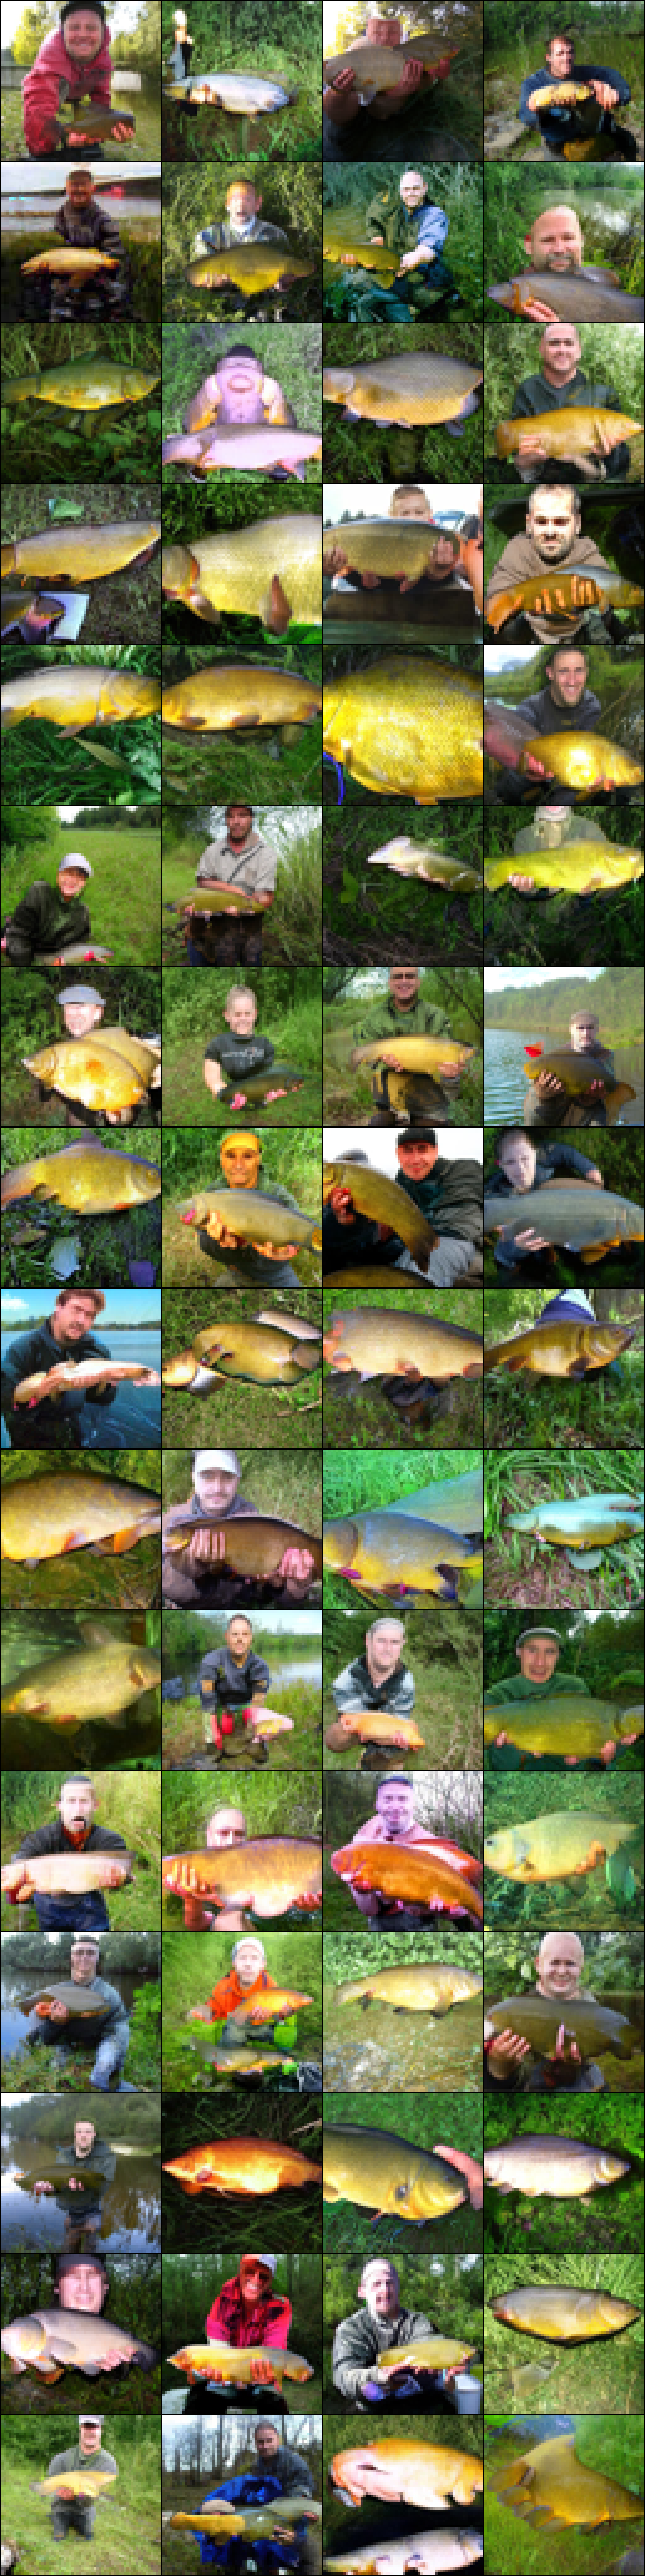

In [4]:
# Set user inputs
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
np.random.seed(seed)
# class_labels = 0,0,0,0 #@param {type:"raw"}
class_id = 0
num_images = 64
class_labels = tuple([class_id] * num_images)
num_iter_list = 64, 16 #@param {type:"raw"}
cfg_scale = 5 #@param {type:"slider", min:1, max:10, step:0.5}
cfg_schedule = "constant" #@param ["linear", "constant"]
temperature = 1.02 #@param {type:"slider", min:0.9, max:1.2, step:0.01}
filter_threshold = 1e-4
samples_per_row = 4 #@param {type:"number"}

label_gen = torch.Tensor(class_labels).long().cuda()
class_embedding = model.class_emb(label_gen)
if not cfg_scale == 1.0:
  class_embedding = torch.cat([class_embedding, model.fake_latent.repeat(label_gen.size(0), 1)], dim=0)

with torch.no_grad():
  with torch.cuda.amp.autocast():
    sampled_images = model.sample(
      cond_list=[class_embedding for _ in range(num_conds)],
      num_iter_list=num_iter_list,
      cfg=cfg_scale, cfg_schedule=cfg_schedule,
      temperature=temperature,
      filter_threshold=filter_threshold,
      fractal_level=0,
      visualize=True,)

# Denormalize images.
pix_mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().view(1, -1, 1, 1)
pix_std = torch.Tensor([0.229, 0.224, 0.225]).cuda().view(1, -1, 1, 1)
sampled_images = sampled_images * pix_std + pix_mean
sampled_images = torch.nn.functional.interpolate(sampled_images, scale_factor=4, mode="nearest")


sampled_images = sampled_images.detach().cpu()




# sampled_images = sampled_images.detach().cpu()

# # Save & display images
# save_image(sampled_images, "samples.png", nrow=int(samples_per_row), normalize=True, value_range=(0, 1))
# samples = Image.open("samples.png")

# from IPython.display import display, clear_output
# clear_output(wait=True)
# display(samples)

In [5]:
# ================================
# 🎯 保留维数最高的一半图像
# ================================
dim_scores = []
for img in sampled_images:
    dim = estimate_box_dimension(img)
    dim_scores.append((img, dim))

# 按维数降序排序
dim_scores.sort(key=lambda x: x[1], reverse=True)

# 保留前一半
top_k = len(dim_scores) // 2
filtered_images = [item[0] for item in dim_scores[:top_k]]

print(f"✅ 保留维数前 50% 图像数: {len(filtered_images)} / {len(sampled_images)}")

# 组装为 tensor
filtered_images = torch.stack(filtered_images)
save_image(filtered_images, "samples_filtered_topk.png", nrow=int(samples_per_row), normalize=True, value_range=(0, 1))
samples = Image.open("samples_filtered_topk.png")

✅ 保留维数前 50% 图像数: 32 / 64


In [ ]:
# ================================
# 🎯 Rejection Sampling via Hausdorff Dimension
# ================================
dim_thresh = 1.4  # 设置维数下限
filtered_images = []

for img in sampled_images:
    dim = estimate_box_dimension(img)
    print(f"Hausdorff dim: {dim:.3f}", end=' | ')
    if dim >= dim_thresh:
        filtered_images.append(img)

if len(filtered_images) == 0:
    print("⚠️ 没有图像通过维数筛选，请尝试降低 dim_thresh")
    filtered_images = sampled_images[:4]  # 退而求其次展示前几张
else:
    print(f"\n✅ 保留图像数: {len(filtered_images)} / {len(sampled_images)}")
    filtered_images = torch.stack(filtered_images)

# 保存 & 显示图像
from torchvision.utils import save_image
from PIL import Image

save_image(filtered_images, "samples_filtered.png", nrow=int(samples_per_row), normalize=True, value_range=(0, 1))
samples = Image.open("samples_filtered.png")




# 4. Download Pre-trained Models on ImageNet 256x256

In [ ]:
model_type = "fractalmar_huge_in256" #@param ["fractalmar_base_in256", "fractalmar_large_in256", "fractalmar_huge_in256"]
num_conds = 5
if model_type == "fractalmar_base_in256":
  download.download_pretrained_fractalmar_base_in256(overwrite=False)
elif model_type == "fractalmar_large_in256":
  download.download_pretrained_fractalmar_large_in256(overwrite=False)
elif model_type == "fractalmar_huge_in256":
  download.download_pretrained_fractalmar_huge_in256(overwrite=False)
else:
  raise NotImplementedError
model = fractalgen.__dict__[model_type](
    guiding_pixel=True,
    num_conds=num_conds
).to(device)
state_dict = torch.load("pretrained_models/{}/checkpoint-last.pth".format(model_type))["model"]
model.load_state_dict(state_dict)
model.eval() # important!

# 5. Sample on ImageNet 256x256

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

In [ ]:
# Set user inputs
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
np.random.seed(seed)
num_iter_list = 64, 16, 16 #@param {type:"raw"}
cfg_scale = 10 #@param {type:"slider", min:1, max:20, step:0.5}
cfg_schedule = "constant" #@param ["linear", "constant"]
temperature = 1.1 #@param {type:"slider", min:0.9, max:1.2, step:0.01}
filter_threshold = 1e-3
class_labels = 207, 360, 388, 113, 355, 980, 323, 979 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

label_gen = torch.Tensor(class_labels).long().cuda()
class_embedding = model.class_emb(label_gen)
if not cfg_scale == 1.0:
  class_embedding = torch.cat([class_embedding, model.fake_latent.repeat(label_gen.size(0), 1)], dim=0)

with torch.no_grad():
  with torch.cuda.amp.autocast():
    sampled_images = model.sample(
      cond_list=[class_embedding for _ in range(num_conds)],
      num_iter_list=num_iter_list,
      cfg=cfg_scale, cfg_schedule=cfg_schedule,
      temperature=temperature,
      filter_threshold=filter_threshold,
      fractal_level=0,
      visualize=True)

# Denormalize images.
pix_mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().view(1, -1, 1, 1)
pix_std = torch.Tensor([0.229, 0.224, 0.225]).cuda().view(1, -1, 1, 1)
sampled_images = sampled_images * pix_std + pix_mean
sampled_images = sampled_images.detach().cpu()

# Save & display images
save_image(sampled_images, "samples.png", nrow=int(samples_per_row), normalize=True, value_range=(0, 1))
samples = Image.open("samples.png")

from IPython.display import display, clear_output
clear_output(wait=True)
display(samples)